# sprint0: global

In [66]:
import numpy as np
np.random.seed(42)

In [67]:
# libraries
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from multiprocessing import Pool

In [68]:
# CONST
RANDOM_STATE = 42

In [69]:
# utils
def fixRandomState(fixed_state):
  np.random.seed(fixed_state)

def exception(condition: bool, notification):
  if(condition == False):
    print("__exception__: ", notification)
    assert(1 == 0)

def verbose(flag: bool, verbose):
  if(flag):
    print("__verbose__: ", verbose)

def note(note):
  print("__note__: ", note)

def hashNP(val: np) -> float:
  return round(np.sqrt(np.sum(val**2)), 10), round(np.sum(val), 10)


# sprint1: build layers class

In [70]:
# static attributies and methods to config layers
AMPHA, INIT_LOC, INIT_STD = 1e-3, 0, 1e-2
LAMDA = 0

In [71]:
EPSILON = 1e-8
BETA_1, BETA_2 = [0.9], [0.999]
for t in range(10**7):
  BETA_1.append(BETA_1[-1] * 0.9)
  BETA_2.append(BETA_2[-1] * 0.999)
BEAT_1, BETA_2 = np.array(BETA_1), np.array(BETA_2)

In [72]:
def configAllLayers(ampha, init_loc, init_std):
  AMPHA, INIT_LOC, INIT_STD = ampha, init_loc, init_std

## Interface

In [73]:
class LayerInterface:
  def __init__(self) -> None:
    self.parameters = np.array([])
    self.input = np.array([])
    self.loss_output = np.array([])

  def set_parameters(self, val: np) -> None:
    self.parameters = val.copy()
  def set_input(self, val: np) -> None:
    self.input = val.copy()
  def set_loss_output(self, val: np) -> None:
    self.loss_output = val.copy()

  def getParameters(self) -> tuple:
    return self.parameters.shape, hashNP(self.parameters)
  def getInput(self) -> tuple:
    return self.input.shape, hashNP(self.input)
  def getLossOutput(self) -> tuple:
    return self.loss_output.shape, hashNP(self.loss_output)

  def transform(self, *argv):
    pass
  def cap(self, *argv):
    pass
  def back(self, *argv):
    pass
  def update(self, *argv):
    pass

  def init_method(self, size_parameters: tuple, fixed_state: int = -1) -> np:
    self.M = np.zeros(shape = size_parameters)
    self.V = np.zeros(shape = size_parameters)
    self.cnt = 0

    if(fixed_state != -1):
      fixRandomState(fixed_state)
    return np.random.normal(loc = INIT_LOC, scale = INIT_STD, size = size_parameters)

  def update_method(self, parameters: np, gradient: np) -> np:
    g = gradient + LAMDA * parameters

    __m, __v = self.M, self.V
    self.M = BETA_1[0] * __m + (1-BETA_1[0]) * g
    self.V = BETA_2[0] * __v + (1-BETA_2[0]) * (g**2)

    self.cnt += 1
    t = self.cnt
    m = self.M / (1-BETA_1[t])
    v = self.V / (1-BETA_2[t])
    return parameters - AMPHA * m / (np.sqrt(v) + EPSILON)

## Padding

In [74]:
class Padding(LayerInterface):
  def __init__(self, a: int, b: int, c: int, d: int) -> None:
    super().__init__()
    self.a, self.b, self.c, self.d = a, b, c, d

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    z = one_point.copy()
    z = tf.convert_to_tensor(z, np.float64)
    padding = tf.constant([[self.a, self.b], [self.c, self.d]])
    z = tf.pad(z, padding, mode ='CONSTANT')
    z = z.numpy()
    return z

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    out = one_output.copy()
    return out[self.a : out.shape[0] - self.b, self.c : out.shape[1] - self.d]


## Convolution

In [75]:
class Convolution(LayerInterface):
  def __init__(self, fixed_state = RANDOM_STATE, size: tuple = (1, 1)) -> None:
    super().__init__()
    self.fixed_state = fixed_state
    self.size = size
    self.filter = self.init_method(self.size, self.fixed_state)

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    z = self.conv_operator(one_point, self.filter)
    return z

  def cap(self, one_point: np) -> None:
    self.one_point = one_point.copy()

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    dF = self.conv_operator(self.one_point, one_output)
    out = Padding(self.size[0]-1, self.size[0]-1, self.size[1]-1, self.size[1]-1).transform(one_output)
    dX = self.conv_operator(out, self.rotate_180(self.filter))
    return dX, dF

  def update(self, gradient: np) -> None:
    self.filter = self.update_method(self.filter, gradient)
    self.set_parameters(self.filter)

  def conv_operator(self, X: np, F: np) -> np:
    a, b = F.shape
    u, v = X.shape[0] - a + 1, X.shape[1] - b + 1
    z = np.zeros((u, v))
    for i in range(u):
      for j in range(v):
        z[i, j] = np.sum(X[i : i + a, j : j + b] * F)
    return z

  def rotate_180(self, A: np) -> np:
    return np.array([row[::-1] for row in A[::-1]])


In [76]:
class MultiConvolution(LayerInterface):
  def __init__(self) -> None:
    pass

## Pooling

In [77]:
class Pooling(LayerInterface):
  def __init__(self) -> None:
    super().__init__()
    pass

  def transform(self, one_point: np, mode: str) -> np:
    exception(one_point.shape[0] % self.size[0] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))
    exception(one_point.shape[1] % self.size[1] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))

    self.set_input(one_point)
    z = np.zeros((one_point.shape[0] // self.size[0], one_point.shape[1] // self.size[1]))
    for i in range(0, one_point.shape[0], self.size[0]):
      for j in range(0, one_point.shape[1], self.size[1]):
        if(mode == 'mean'):
          z[i // self.size[0], j // self.size[1]] = np.mean(one_point[i : i + self.size[0], j : j + self.size[1]])
        elif(mode == 'max'):
          z[i // self.size[0], j // self.size[1]] = np.max(one_point[i : i + self.size[0], j : j + self.size[1]])
    return z

  def zoom(self, one_output: np) -> np:
    zoom = np.zeros((one_output.shape[0] * self.size[0], one_output.shape[1] * self.size[1]))
    for i in range(zoom.shape[0]):
      for j in range(zoom.shape[1]):
        zoom[i, j] = one_output[i // self.size[0], j // self.size[1]]
    return zoom


In [78]:
class AveragePooling(Pooling):
  def __init__(self, size: tuple = (1, 1)) -> None:
    super().__init__()
    self.size = size

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return super().transform(one_point, 'mean')

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    return self.zoom(one_output) / (self.size[0] * self.size[1])


In [79]:
class MaxPooling(Pooling):
  def __init__(self, size: tuple = (1, 1)) -> None:
    super().__init__()
    self.size = size

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return super().transform(one_point, 'max')

  def cap(self, one_point: np) -> np:
    exception(one_point.shape[0] % self.size[0] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))
    exception(one_point.shape[1] % self.size[1] == 0, "Pooling > transform: size of pooling not valid {} {}".format(one_point.shape, self.size))

    self.mask = np.zeros((one_point.shape[0], one_point.shape[1]))
    for i in range(0, one_point.shape[0], self.size[0]):
      for j in range(0, one_point.shape[1], self.size[1]):
        li, lj = i, j
        for k in range(i, i + self.size[0]):
          for t in range(j, j + self.size[1]):
            if(one_point[k][t] > one_point[li][lj]):
              li, lj = k, t
        self.mask[li][lj] = 1

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    return self.zoom(one_output) * self.mask


## Flatten

In [80]:
class Flatten(LayerInterface):
  def __init__(self):
    super().__init__()
    pass

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    z = one_point.copy()
    length = 1
    for i in range(len(z.shape)):
      length *= z.shape[i]
    return z.reshape(length, 1)

  def cap(self, one_point: np) -> None:
    self.shape_one_point = one_point.shape

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    out = one_output.copy()
    out = np.reshape(out, self.shape_one_point)
    return out


## Fully Connected

In [81]:
class Dense(LayerInterface):
  def __init__(self, fixed_state = RANDOM_STATE, size_output: int = 1) -> None:
    super().__init__()
    self.fixed_state = fixed_state
    self.size_output = size_output
    self.W = self.init_method((self.size_output, 1), self.fixed_state)

  def check_shape_to_init_method(self, one_point: np) -> None:
    if(self.W.shape != (self.size_output, one_point.shape[0] + 1)):
      self.W = self.init_method((self.size_output, one_point.shape[0] + 1), self.fixed_state)

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    self.check_shape_to_init_method(one_point)
    z = one_point.copy()
    z =  np.append(z, np.array([[1]]), axis = 0) #$ append 1 at last
    return np.matmul(self.W, z)

  def cap(self, one_point: np) -> None:
    self.check_shape_to_init_method(one_point)
    z = one_point.copy()
    self.append_one_point = np.append(z, np.array([[1]]), axis = 0)  #$ append 1 at last

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    out = one_output.copy()
    dW = np.matmul(out, self.append_one_point.T)
    dX = np.matmul(self.W.T, out)
    return dX[:-1], dW

  def update(self, gradient: np) -> np:
    self.W = self.update_method(self.W, gradient)
    self.set_parameters(self.W)

## Activation

In [82]:
class Activation(LayerInterface):
  def __init__(self) -> None:
    super().__init__()
    pass

In [83]:
class ReLU(Activation):
  def __init__(self) -> None:
    super().__init__()
    self.rate = 0
    pass

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return self.relu(one_point)

  def cap(self, one_point: np) -> None:
    self.mask = np.where(one_point >= 0, 1, self.rate)

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    return one_output.copy() * self.mask

  def relu(self, one_point: np) -> np:
    x = one_point.copy()
    return np.where(x >= 0, x, self.rate * x)


In [84]:
class Sigmoid(Activation):
  def __init__(self) -> None:
    super().__init__()
    pass

  def transform(self, one_point: np) -> np:
    self.set_input(one_point)
    return self.sigmoid(one_point)

  def cap(self, one_point: np) -> None:
    self.one_point = one_point.copy()

  def back(self, one_output: np) -> np:
    self.set_loss_output(one_output)
    sig = self.sigmoid(self.one_point)
    return one_output.copy() * sig * (1 - sig)

  def sigmoid(self, x: np) -> np:
    return 1 / (1 + np.exp(-x))


## Loss (final layer)

In [85]:
class Loss(LayerInterface):
  def __init__(self) -> None:
    super().__init__()
    pass

In [86]:
class StableBinaryCrossEntropy(Loss):
  def __init__(self) -> None:
    super().__init__()
    pass

  def transform(self, one_point: np, one_y: np) -> np:
    self.set_input(one_point)
    z = one_point.copy()
    y = one_y.copy()
    # return -y * np.log(a) -(1-y) * np.log(1-a)
    # print("loss: ", -(-y * np.log(1 + np.exp(-z)) + (1 - y) * (-z - np.log(1 + np.exp(-z)))))
    return -(-y * np.log(1 + np.exp(-z)) + (1 - y) * (-z - np.log(1 + np.exp(-z))))

  def cap(self, one_point: np, one_y: np) -> None:
    self.one_point = one_point.copy()
    self.one_y = one_y.copy()

  def back(self) -> np:
    z = self.one_point
    y = self.one_y
    a = 1 / (1 + np.exp(-z))
    return a - y


# sprint2: build Network class

In [87]:
class Network:
  def __init__(self, n_player: int) -> None:
    self.network = []
    self.n_player = n_player

  def add(self, layers) -> None:
    if(isinstance(layers, list)):
      self.network.extend(layers)
    else:
      self.network.append(layers)

  def addLoss(self, loss_layer: Loss) -> None:
    exception(isinstance(loss_layer, Loss), "Network > addLoss: not is a Loss layer")

    self.network.append(loss_layer)

###################################################################################################
  def forward_operator(self, one_point: np, df) -> np:
    z = one_point.copy()
    for i, layer in enumerate(self.network[:-1]): #$ not there loss
      layer.cap(z)
      z = layer.transform(z).copy()
      # catch
      df['layer {}'.format(i)].append(layer.getInput())
      df['layer {}'.format(i)].append(layer.getParameters())
    return z

  def backprop_operator(self, one_output: np, df) -> np:
    out = one_output.copy()
    for i in range(len(self.network)-2, -1, -1):
      layer = self.network[i]
      der = layer.back(out)
      if(isinstance(der, tuple)):
        out = der[0]
        layer.update(der[1])
      else:
        out = der
      # catch
      df['layer {}'.format(i)].append(layer.getLossOutput())
      df['layer {}'.format(i)].append(layer.getParameters())
    return out

###################################################################################################
  def fit_one_point(self, one_point: np, one_y: np, noisy = False) -> np:
    df = defaultdict(list) # catch
    z = self.forward_operator(one_point, df) # forward
    self.network[-1].cap(z, one_y)
    loss_value = round(np.sum(self.network[-1].transform(z, one_y)), 6) # return loss_value
    out = self.network[-1].back() # backprop
    self.backprop_operator(out, df)

    df['row meaning'].extend(["Hash(input)", "before Hash(params)", "Hash(dL/douput)", "after Hash(params)"])
    self.df = pd.DataFrame(df)
    if(noisy):
      verbose(noisy, "Network > fit_one_point: ")
      print(self.df)
      print("z_to_loss: ", z)
      print("loss_value: ", loss_value)
      print("dL/dz: ", out)
    return loss_value

###################################################################################################
  def fit(self, set_points: np, set_y: np, num_epoch: int = 100, noisy = False) -> None:
    exception(set_points.shape[0] == set_y.shape[0], "Network > fit_set_points: size of sample {} {}".format(set_points.shape, set_y.shape))

    self.mean_loss = []
    for _ in range(num_epoch):
      mean_loss = []
      for i, one_point in enumerate(set_points):
        one_y = set_y[i]
        loss_value = self.fit_one_point(one_point, one_y, noisy = False)
        mean_loss.append(loss_value)
        # return !!!
      mean_loss = np.mean(mean_loss)
      self.mean_loss.append(mean_loss)
      if(noisy):
        verbose(noisy, "Network > fit > (epoch) = ({}): mean_loss_iteration_in_epoch = {}".format(_, mean_loss))
        if(_ % 20 == 0):
          self.visualiseLayers()
    if(noisy):
      self.plotLossProgress()
      self.visualiseLayers()
    # return self.mean_loss

###################################################################################################
  def imageNP(self, Image: np):
    plt.rcParams.update({'font.size': 2}) #@
    A = Image.copy()
    if(len(A.shape) == 2):
      plt.imshow(A, cmap='viridis')
      plt.rcParams.update({'font.size': 10}) #@
      return 1
    else:
      plt.rcParams.update({'font.size': 10}) #@
      return 0
    return 0

  def visualiseLayers(self):
    ncolumn, cnt = self.n_player, 1
    plt.figure(figsize=(30, 30 * ncolumn)) #$ figsize
    for i, layer in enumerate(self.network):
      if(cnt <= ncolumn):
        plt.subplot(1, ncolumn, cnt)
        cnt += self.imageNP(layer.parameters)
    plt.show()

  def plotLossProgress(self):
    num_epoch = len(self.mean_loss)
    plt.plot(self.mean_loss[num_epoch//2:], label = 'mean_loss_iteration_in_epoch')
    plt.title('Loss Progress')
    plt.xlabel('epoch (from {}+)'.format(num_epoch//2))
    plt.ylabel('mean_loss')
    plt.legend()
    plt.grid()
    plt.show()

###################################################################################################
  def getOutputLayer(self, one_point: np, index: int, noisy = False) -> np:
    z = one_point.copy()
    for i, layer in enumerate(self.network[:index+1]):
      if(noisy):
        verbose(noisy, "Network > getOutputLayer > (layer) = ({}): ".format(i))
        print("Image(input): ")
        self.imageNP(z)
        plt.show()
      z = layer.transform(z).copy()
      if(noisy):
        print("Hash(input): ", layer.getInput())
        print("Hash(params): ", layer.getParameters())
        print("Hash(output): ", hashNP(z))
    return z

  def predict(self, set_points: np) -> np:
    predictions = np.array([])
    for i, one_point in enumerate(set_points):
      predictions = np.append(predictions, self.getOutputLayer(one_point, len(self.network)-2))
    return predictions


#sprint3: config and architecture

In [88]:
net = Network(5)
net.add([Convolution(size = (7, 7)), ReLU()])
net.add([Convolution(size = (3, 3)), ReLU()])

net.add([MaxPooling(size = (2, 2))])

net.add(Flatten())

net.add([Dense(size_output = 16), ReLU()])
net.add([Dense(size_output = 8), ReLU()])

net.add(Dense(size_output = 1))
net.addLoss(StableBinaryCrossEntropy())

# sprint4: data

In [89]:
from keras.datasets import mnist

- load data

In [90]:
# load data
(x_in, y_in), (x_out, y_out) = mnist.load_data()

In [91]:
# print(x_in)
print(y_in)
# print(x_out)
print(y_out)

[5 0 4 ... 5 6 8]
[7 2 1 ... 4 5 6]


- select data:
  - digit 0 and 1
  - #train: 100
  - #test: 100

In [92]:
indexing = np.where((y_in == 0) | (y_in == 1))
y_in = y_in[indexing]
x_in = x_in[indexing]
y_in

array([0, 1, 1, ..., 1, 0, 1], dtype=uint8)

In [93]:
indexing = np.where((y_out == 0) | (y_out == 1))
y_out = y_out[indexing]
x_out = x_out[indexing]
y_out

array([1, 0, 1, ..., 1, 0, 1], dtype=uint8)

In [94]:
y_in = y_in[:100]
x_in = x_in[:100]
y_out = y_out[:100]
x_out = x_out[:100]

- cast type and shape

In [95]:
print(type(x_in), x_in.shape)
print(type(x_out), x_out.shape)
print(type(y_in), y_in.shape)
print(type(y_out), y_out.shape)

<class 'numpy.ndarray'> (100, 28, 28)
<class 'numpy.ndarray'> (100, 28, 28)
<class 'numpy.ndarray'> (100,)
<class 'numpy.ndarray'> (100,)


- observe data

In [96]:
print("#image 1: ", np.sum(y_in == 1))
print("#image 0: ", np.sum(y_in == 0))
print("#image: ", y_in.shape)

#image 1:  57
#image 0:  43
#image:  (100,)


#sprint5: fitting and testing

### fitting

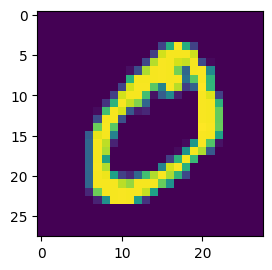

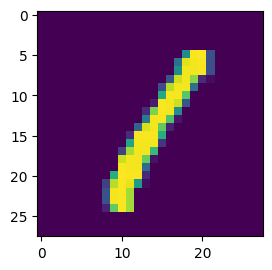

In [97]:
# review data
plt.subplot(1, 2, 1)
plt.imshow(x_in[0])
plt.show()
plt.subplot(1, 2, 2)
plt.imshow(x_in[1])
plt.show()

__verbose__:  Network > fit > (epoch) = (0): mean_loss_iteration_in_epoch = -53.09062389999999


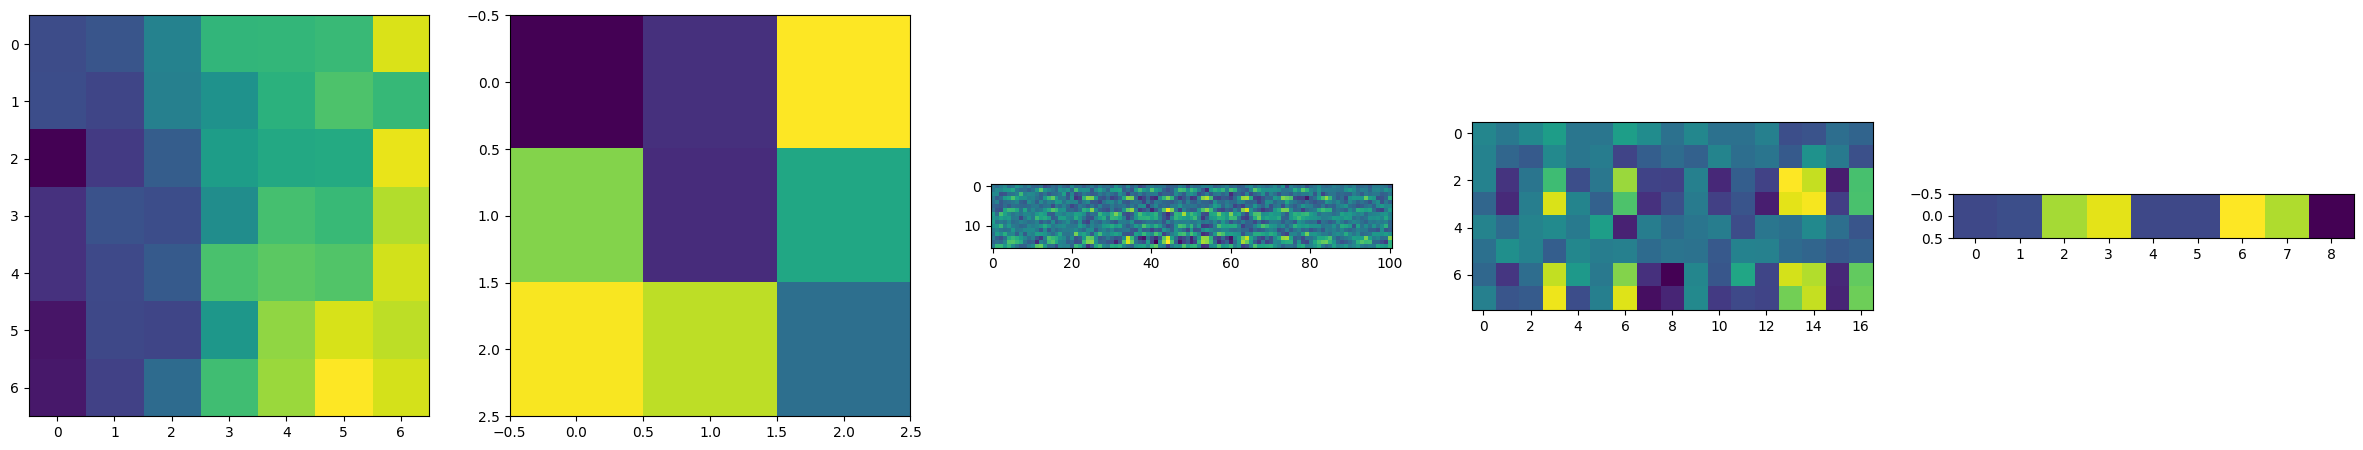

__verbose__:  Network > fit > (epoch) = (1): mean_loss_iteration_in_epoch = -8.68053658
__verbose__:  Network > fit > (epoch) = (2): mean_loss_iteration_in_epoch = -1.29619593
__verbose__:  Network > fit > (epoch) = (3): mean_loss_iteration_in_epoch = 0.09994266000000002
__verbose__:  Network > fit > (epoch) = (4): mean_loss_iteration_in_epoch = 0.15727287
__verbose__:  Network > fit > (epoch) = (5): mean_loss_iteration_in_epoch = 0.18555332
__verbose__:  Network > fit > (epoch) = (6): mean_loss_iteration_in_epoch = 0.19401263000000005
__verbose__:  Network > fit > (epoch) = (7): mean_loss_iteration_in_epoch = 0.19486743
__verbose__:  Network > fit > (epoch) = (8): mean_loss_iteration_in_epoch = 0.19218425999999997
__verbose__:  Network > fit > (epoch) = (9): mean_loss_iteration_in_epoch = 0.18770008000000002
__verbose__:  Network > fit > (epoch) = (10): mean_loss_iteration_in_epoch = 0.18227481999999998
__verbose__:  Network > fit > (epoch) = (11): mean_loss_iteration_in_epoch = 0.042

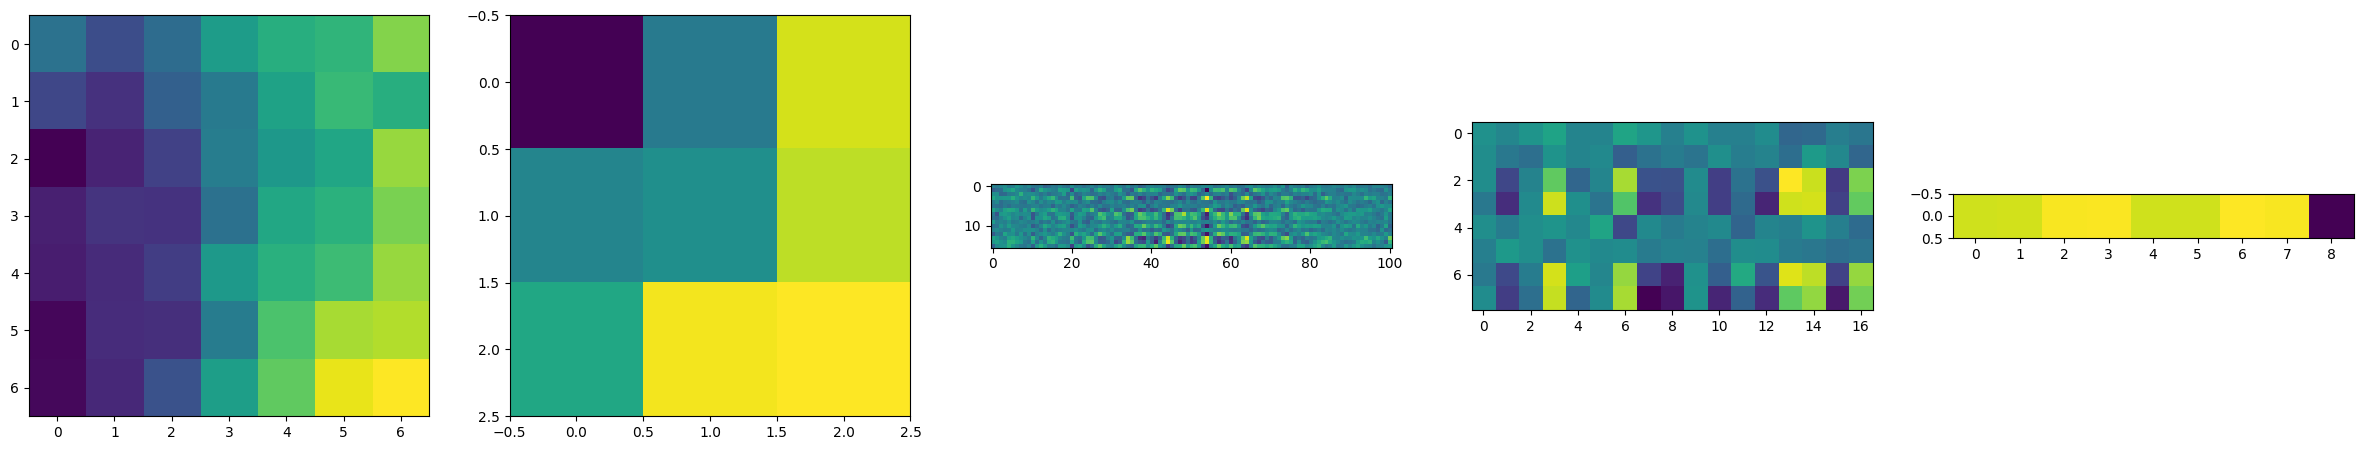

__verbose__:  Network > fit > (epoch) = (21): mean_loss_iteration_in_epoch = 0.11929025999999997
__verbose__:  Network > fit > (epoch) = (22): mean_loss_iteration_in_epoch = 0.1146418
__verbose__:  Network > fit > (epoch) = (23): mean_loss_iteration_in_epoch = 0.11015993
__verbose__:  Network > fit > (epoch) = (24): mean_loss_iteration_in_epoch = 0.10584676
__verbose__:  Network > fit > (epoch) = (25): mean_loss_iteration_in_epoch = 0.10170095
__verbose__:  Network > fit > (epoch) = (26): mean_loss_iteration_in_epoch = 0.09771974000000001
__verbose__:  Network > fit > (epoch) = (27): mean_loss_iteration_in_epoch = 0.09389875
__verbose__:  Network > fit > (epoch) = (28): mean_loss_iteration_in_epoch = 0.09023299
__verbose__:  Network > fit > (epoch) = (29): mean_loss_iteration_in_epoch = 0.08671701999999999
__verbose__:  Network > fit > (epoch) = (30): mean_loss_iteration_in_epoch = 0.08334551000000001
__verbose__:  Network > fit > (epoch) = (31): mean_loss_iteration_in_epoch = 0.080113

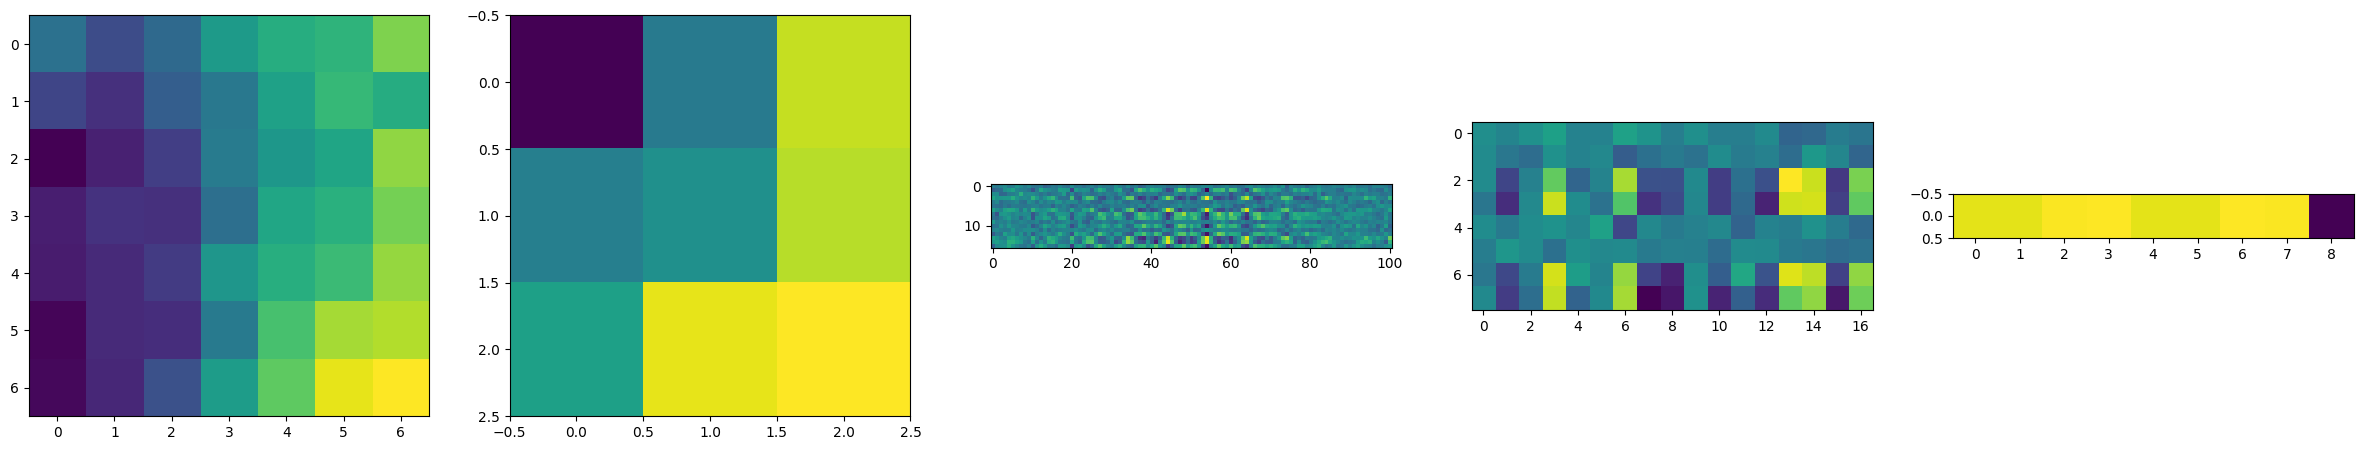

__verbose__:  Network > fit > (epoch) = (41): mean_loss_iteration_in_epoch = 0.05427107
__verbose__:  Network > fit > (epoch) = (42): mean_loss_iteration_in_epoch = 0.05222948000000001
__verbose__:  Network > fit > (epoch) = (43): mean_loss_iteration_in_epoch = 0.05026971
__verbose__:  Network > fit > (epoch) = (44): mean_loss_iteration_in_epoch = 0.048388360000000005
__verbose__:  Network > fit > (epoch) = (45): mean_loss_iteration_in_epoch = 0.04658176000000001
__verbose__:  Network > fit > (epoch) = (46): mean_loss_iteration_in_epoch = 0.044846880000000006
__verbose__:  Network > fit > (epoch) = (47): mean_loss_iteration_in_epoch = -0.004657269999999996
__verbose__:  Network > fit > (epoch) = (48): mean_loss_iteration_in_epoch = 0.04181154
__verbose__:  Network > fit > (epoch) = (49): mean_loss_iteration_in_epoch = 0.040257930000000004
__verbose__:  Network > fit > (epoch) = (50): mean_loss_iteration_in_epoch = 0.03876381000000001
__verbose__:  Network > fit > (epoch) = (51): mean_l

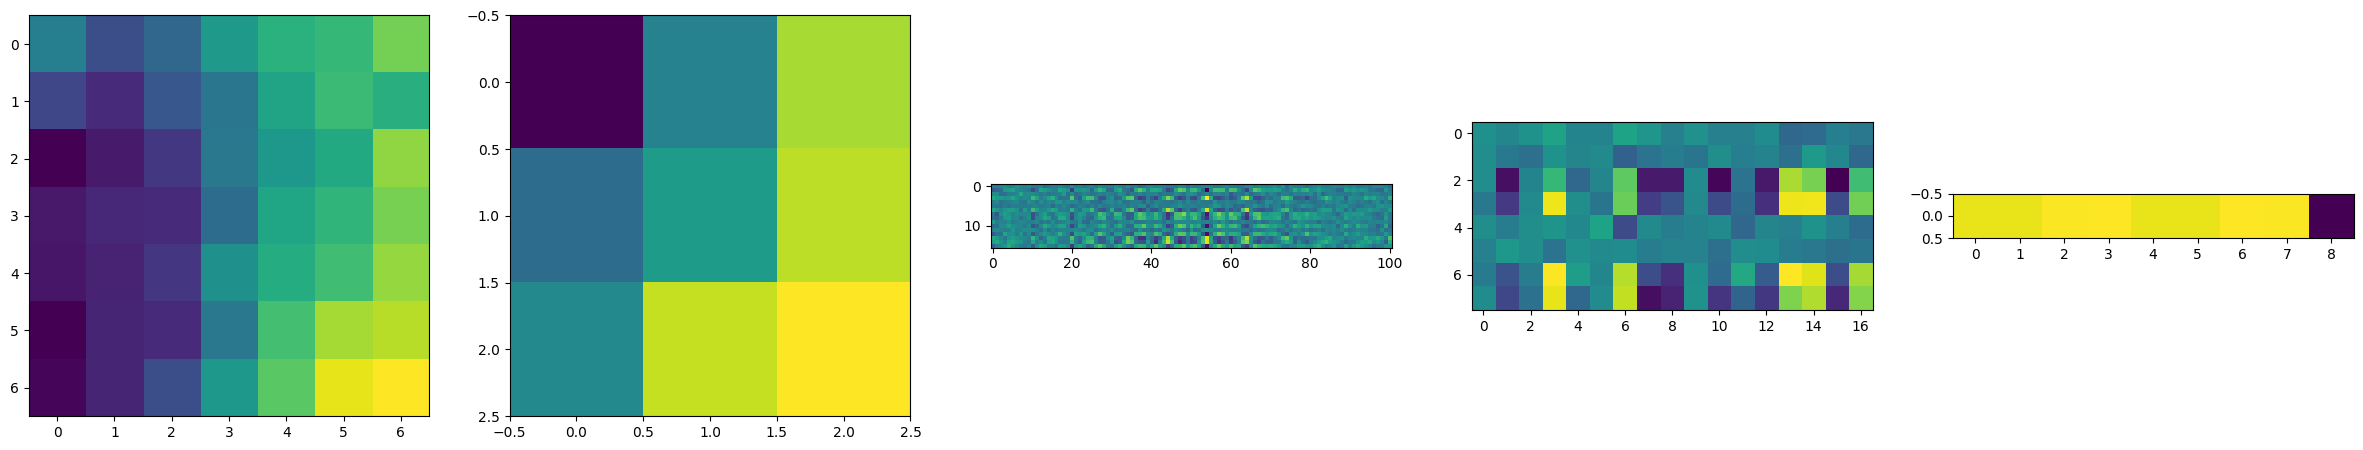

__verbose__:  Network > fit > (epoch) = (61): mean_loss_iteration_in_epoch = 0.02570215
__verbose__:  Network > fit > (epoch) = (62): mean_loss_iteration_in_epoch = 0.024769529999999994
__verbose__:  Network > fit > (epoch) = (63): mean_loss_iteration_in_epoch = 0.02387215000000001
__verbose__:  Network > fit > (epoch) = (64): mean_loss_iteration_in_epoch = 0.02300855
__verbose__:  Network > fit > (epoch) = (65): mean_loss_iteration_in_epoch = 0.022177310000000002
__verbose__:  Network > fit > (epoch) = (66): mean_loss_iteration_in_epoch = 0.021377169999999997
__verbose__:  Network > fit > (epoch) = (67): mean_loss_iteration_in_epoch = 0.020606879999999998
__verbose__:  Network > fit > (epoch) = (68): mean_loss_iteration_in_epoch = 0.01986531
__verbose__:  Network > fit > (epoch) = (69): mean_loss_iteration_in_epoch = 0.01915124
__verbose__:  Network > fit > (epoch) = (70): mean_loss_iteration_in_epoch = 0.018463649999999998
__verbose__:  Network > fit > (epoch) = (71): mean_loss_itera

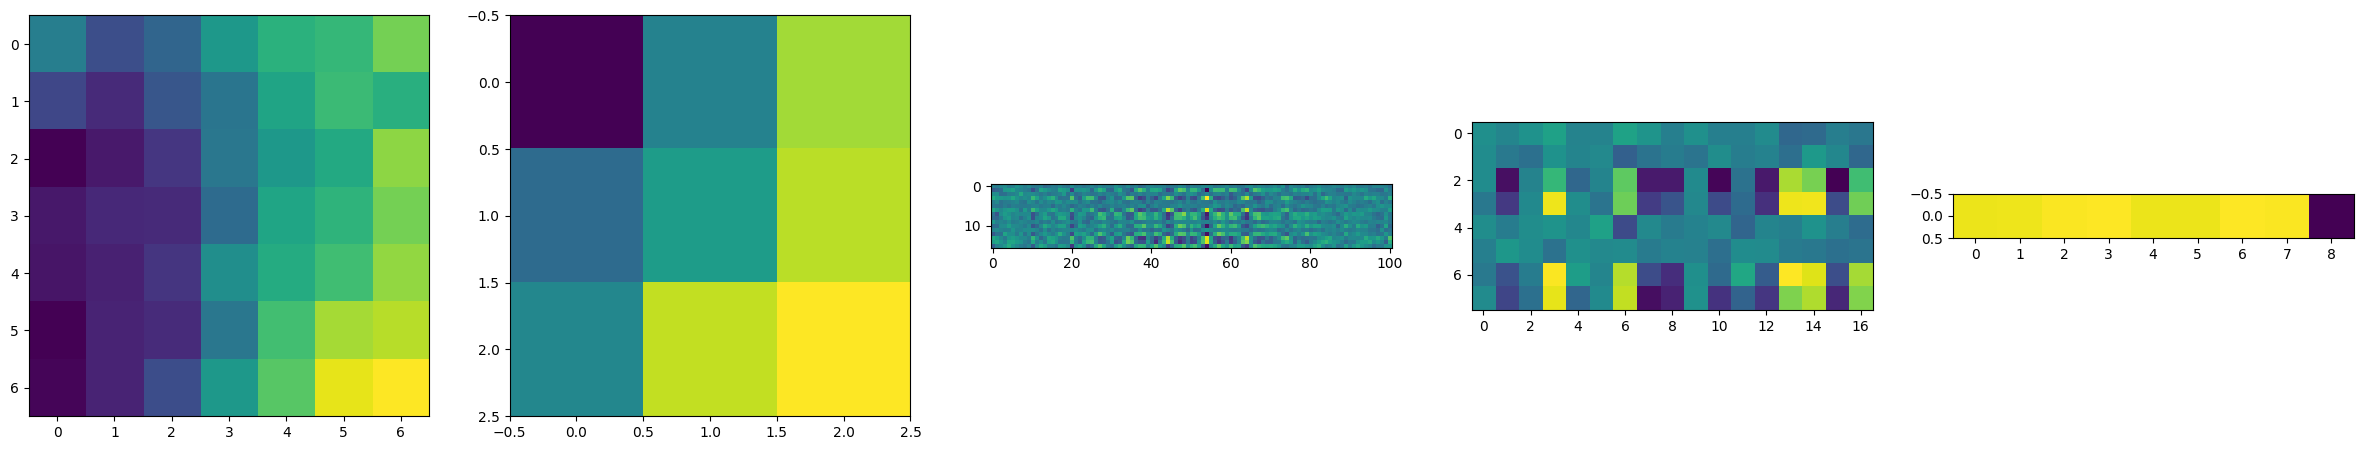

__verbose__:  Network > fit > (epoch) = (81): mean_loss_iteration_in_epoch = 0.012379740000000002
__verbose__:  Network > fit > (epoch) = (82): mean_loss_iteration_in_epoch = 0.011940160000000002
__verbose__:  Network > fit > (epoch) = (83): mean_loss_iteration_in_epoch = 0.01151653
__verbose__:  Network > fit > (epoch) = (84): mean_loss_iteration_in_epoch = 0.01110819
__verbose__:  Network > fit > (epoch) = (85): mean_loss_iteration_in_epoch = 0.01071469
__verbose__:  Network > fit > (epoch) = (86): mean_loss_iteration_in_epoch = 0.010335180000000005
__verbose__:  Network > fit > (epoch) = (87): mean_loss_iteration_in_epoch = 0.00996943
__verbose__:  Network > fit > (epoch) = (88): mean_loss_iteration_in_epoch = 0.00961689
__verbose__:  Network > fit > (epoch) = (89): mean_loss_iteration_in_epoch = 0.00927698
__verbose__:  Network > fit > (epoch) = (90): mean_loss_iteration_in_epoch = 0.008949209999999999
__verbose__:  Network > fit > (epoch) = (91): mean_loss_iteration_in_epoch = 0.0

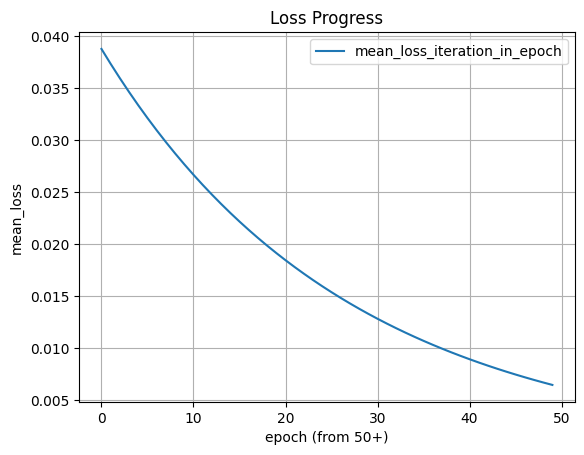

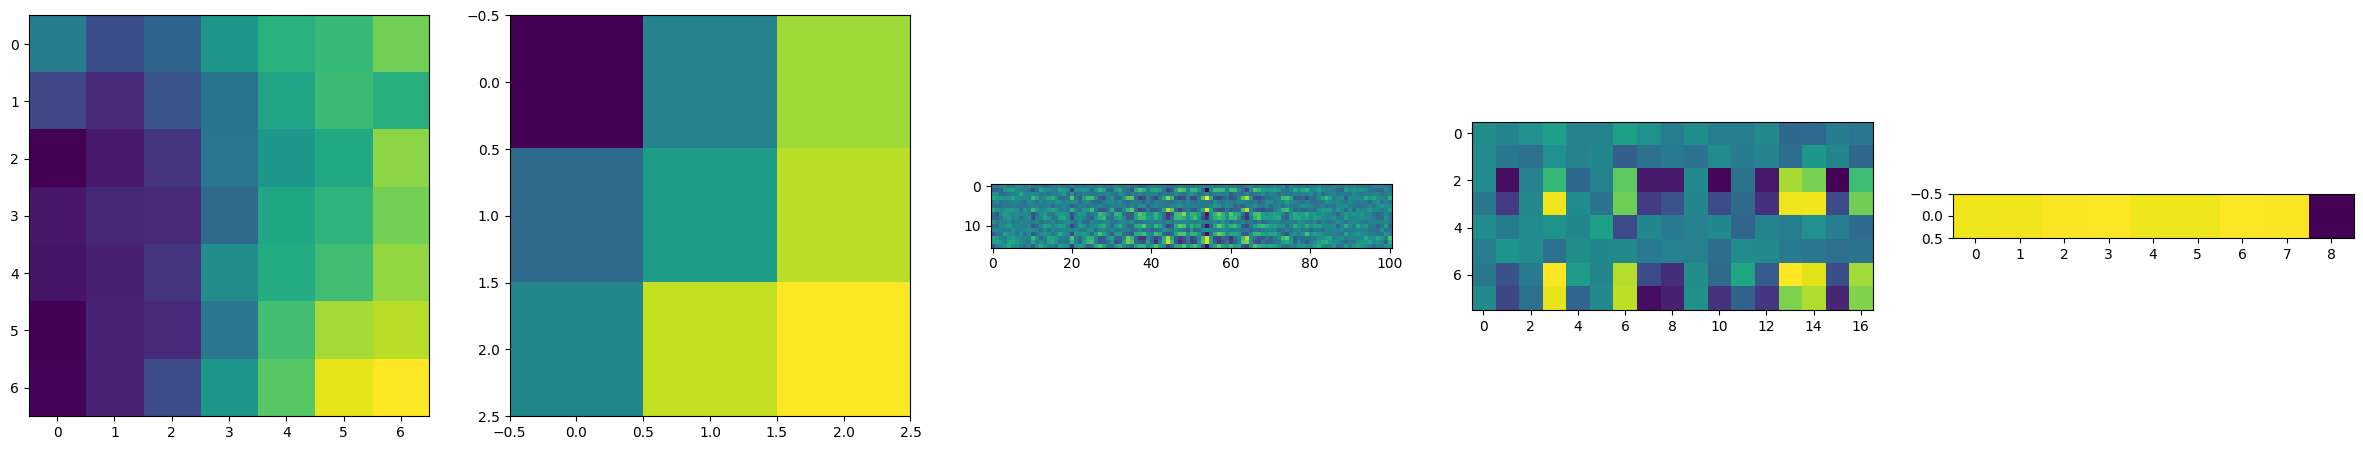

In [98]:
# fit through data_in
num_epoch = 100
net.fit(x_in, y_in, num_epoch = num_epoch, noisy = True)

### testing

In [99]:
# try step predict
z = net.predict(x_in)
print(z)
preds = 1 / (1 + np.exp(-z))
print(preds)
preds = np.where(preds >= 0.5, 1, 0)

[-4.20283808 16.41377455 27.4929704  18.84418196 18.76462732 -4.20283808
 16.3317128  14.25104955 -4.20283808 -4.20283808 24.75680964 -4.20283808
 -4.20283808 16.87622813 -4.20283808 21.06855302 -4.20283808 -4.20283808
 20.35581506 18.4127687  -4.20283808 19.88144307 27.4142298  -4.20283808
 -4.20283808 -4.20283808 18.70016415 18.5093435  16.88187014 23.46242254
 -4.20283808 22.49909814 21.75553423 -4.20283808 -4.20283808 -4.20283808
 -4.20283808 15.05600846 32.61746909 18.01127398 22.09554943 -4.20283808
 -4.20283808 21.42768734 29.23716213 22.11527684 -4.20283808 25.46985942
 16.9270383  16.84234927 -4.20283808 31.0625105  -4.20283808 -4.20283808
 29.80457204 -4.20283808 14.02588382 -4.20283808 24.50439349 -4.20283808
 -4.20283808 -4.20283808 25.69098678 -4.20283808 32.14938527 -4.20283808
 21.97423244 12.04709489 18.13702771 -4.20283808 22.0201462  -4.20283808
 -4.20283808 -4.20283808 17.77886099 20.31200292 23.50129931 -4.20283808
 -4.20283808 22.48644302 22.51528988 19.91359815 27

- after train

In [100]:
print("accuray after train: ", round(np.sum(preds == y_in) / preds.shape[0], 6))

accuray after train:  1.0


- test data_out

In [101]:
z = net.predict(x_out)
# print(z)
preds = 1 / (1 + np.exp(-z))
# print(preds)
preds = np.where(preds >= 0.5, 1, 0)
print("accuray of data_out: ", round(np.sum(preds == y_out) / preds.shape[0], 6))

accuray of data_out:  1.0


# sprint5: *the result of visualization experiment*

- digit 0

__verbose__:  Network > getOutputLayer > (layer) = (0): 
Image(input): 


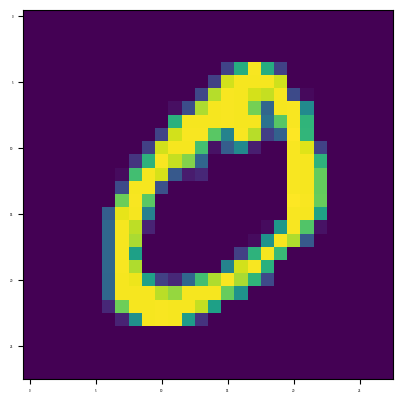

Hash(input):  ((28, 28), (106.7567328088, 31095))
Hash(params):  ((7, 7), (0.4377102288, 1.2329535528))
Hash(output):  (3025.0760958694, 36927.7814881512)
__verbose__:  Network > getOutputLayer > (layer) = (1): 
Image(input): 


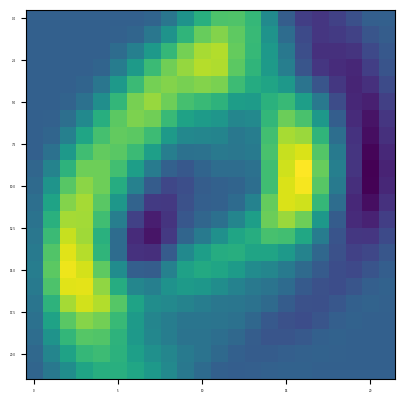

Hash(input):  ((22, 22), (3025.0760958694, 36927.7814881512))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (2938.675902586, 43040.396206871)
__verbose__:  Network > getOutputLayer > (layer) = (2): 
Image(input): 


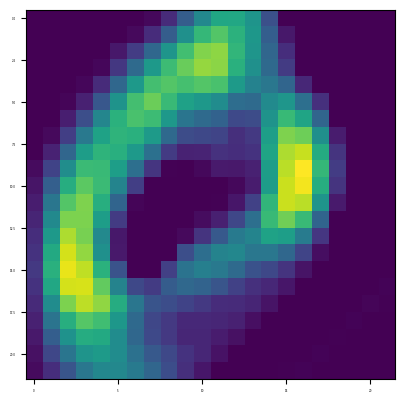

Hash(input):  ((22, 22), (2938.675902586, 43040.396206871))
Hash(params):  ((3, 3), (0.2960572253, 0.8771007973))
Hash(output):  (2349.4517387964, 34883.1653981173)
__verbose__:  Network > getOutputLayer > (layer) = (3): 
Image(input): 


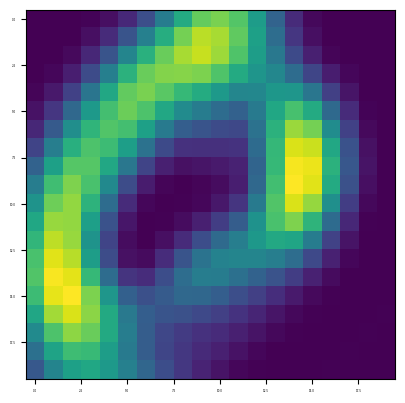

Hash(input):  ((20, 20), (2349.4517387964, 34883.1653981173))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (2349.4517387964, 34883.1653981173)
__verbose__:  Network > getOutputLayer > (layer) = (4): 
Image(input): 


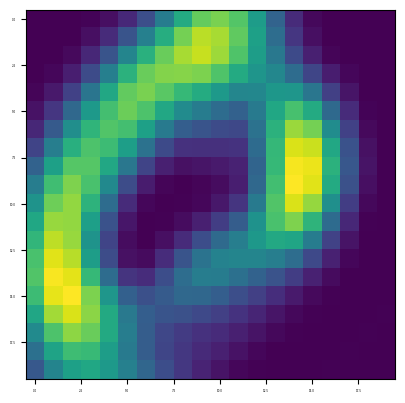

Hash(input):  ((20, 20), (2349.4517387964, 34883.1653981173))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (1394.740811627, 11065.2181500518)
__verbose__:  Network > getOutputLayer > (layer) = (5): 
Image(input): 


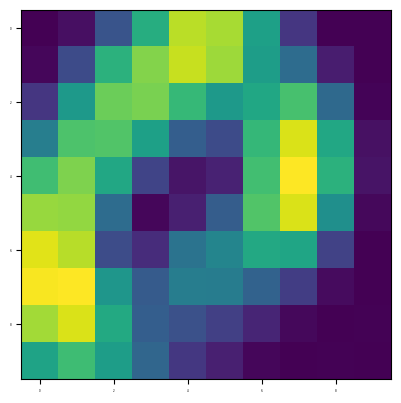

Hash(input):  ((10, 10), (1394.740811627, 11065.2181500518))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (1394.740811627, 11065.2181500518)
__verbose__:  Network > getOutputLayer > (layer) = (6): 
Image(input): 


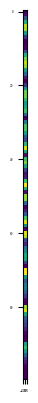

Hash(input):  ((100, 1), (1394.740811627, 11065.2181500518))
Hash(params):  ((16, 101), (1.1811227337, 7.2352984017))
Hash(output):  (705.1601581467, 1092.0329024496)
__verbose__:  Network > getOutputLayer > (layer) = (7): 
Image(input): 


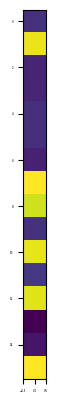

Hash(input):  ((16, 1), (705.1601581467, 1092.0329024496))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (679.234010434, 1662.7379280808)
__verbose__:  Network > getOutputLayer > (layer) = (8): 
Image(input): 


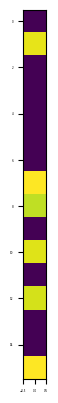

Hash(input):  ((16, 1), (679.234010434, 1662.7379280808))
Hash(params):  ((8, 17), (0.3685438365, -0.2185187824))
Hash(output):  (154.108523413, -320.2055855638)
__verbose__:  Network > getOutputLayer > (layer) = (9): 
Image(input): 


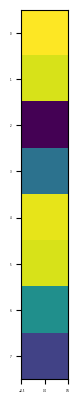

Hash(input):  ((8, 1), (154.108523413, -320.2055855638))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (0.0, 0.0)
__verbose__:  Network > getOutputLayer > (layer) = (10): 
Image(input): 


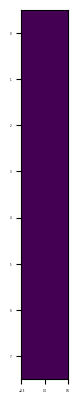

Hash(input):  ((8, 1), (0.0, 0.0))
Hash(params):  ((1, 9), (4.2071201491, -3.8035055264))
Hash(output):  (4.2028380775, -4.2028380775)


array([[-4.20283808]])

In [102]:
net.getOutputLayer(x_in[0], len(net.network)-2, noisy = True)

- digit 1

__verbose__:  Network > getOutputLayer > (layer) = (0): 
Image(input): 


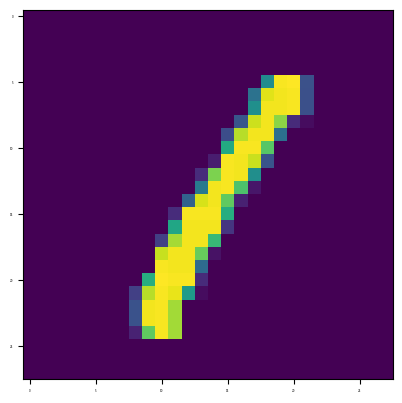

Hash(input):  ((28, 28), (73.4098086089, 17135))
Hash(params):  ((7, 7), (0.4377102288, 1.2329535528))
Hash(output):  (2609.21533658, 20013.1947236213)
__verbose__:  Network > getOutputLayer > (layer) = (1): 
Image(input): 


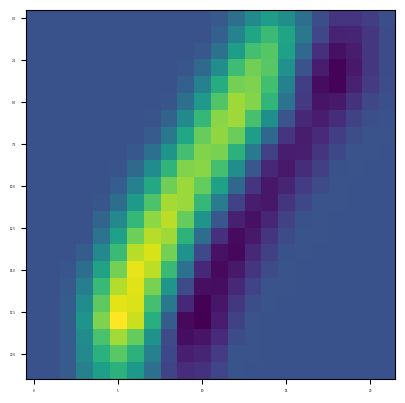

Hash(input):  ((22, 22), (2609.21533658, 20013.1947236213))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (2503.0961461782, 26568.724112092)
__verbose__:  Network > getOutputLayer > (layer) = (2): 
Image(input): 


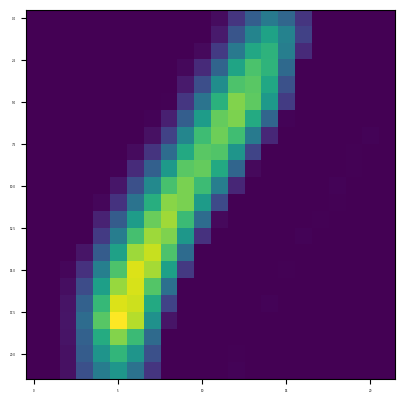

Hash(input):  ((22, 22), (2503.0961461782, 26568.724112092))
Hash(params):  ((3, 3), (0.2960572253, 0.8771007973))
Hash(output):  (2002.4978086901, 22111.6717708962)
__verbose__:  Network > getOutputLayer > (layer) = (3): 
Image(input): 


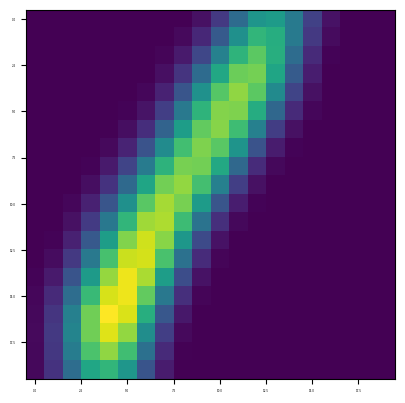

Hash(input):  ((20, 20), (2002.4978086901, 22111.6717708962))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (2002.4978086901, 22111.6717708962)
__verbose__:  Network > getOutputLayer > (layer) = (4): 
Image(input): 


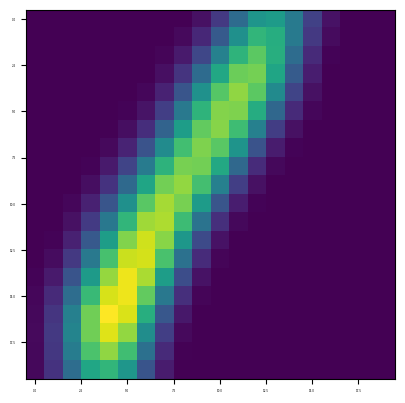

Hash(input):  ((20, 20), (2002.4978086901, 22111.6717708962))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (1210.5692019524, 7366.3874422228)
__verbose__:  Network > getOutputLayer > (layer) = (5): 
Image(input): 


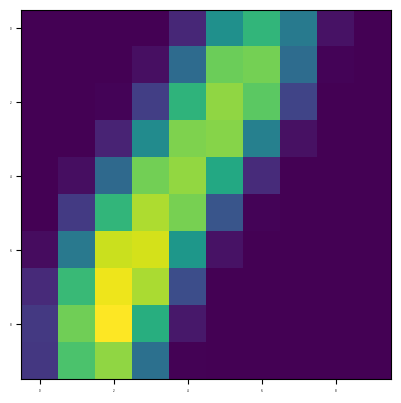

Hash(input):  ((10, 10), (1210.5692019524, 7366.3874422228))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (1210.5692019524, 7366.3874422228)
__verbose__:  Network > getOutputLayer > (layer) = (6): 
Image(input): 


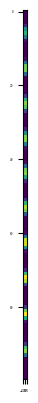

Hash(input):  ((100, 1), (1210.5692019524, 7366.3874422228))
Hash(params):  ((16, 101), (1.1811227337, 7.2352984017))
Hash(output):  (455.7049359528, 641.1747566433)
__verbose__:  Network > getOutputLayer > (layer) = (7): 
Image(input): 


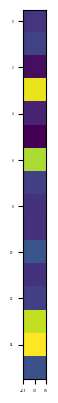

Hash(input):  ((16, 1), (455.7049359528, 641.1747566433))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (443.6202874748, 908.6843076533)
__verbose__:  Network > getOutputLayer > (layer) = (8): 
Image(input): 


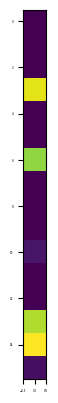

Hash(input):  ((16, 1), (443.6202874748, 908.6843076533))
Hash(params):  ((8, 17), (0.3685438365, -0.2185187824))
Hash(output):  (109.9462447196, 198.6883827604)
__verbose__:  Network > getOutputLayer > (layer) = (9): 
Image(input): 


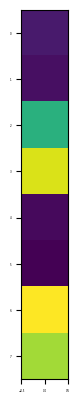

Hash(input):  ((8, 1), (109.9462447196, 198.6883827604))
Hash(params):  ((0,), (0.0, 0.0))
Hash(output):  (109.5598050113, 215.6201718589)
__verbose__:  Network > getOutputLayer > (layer) = (10): 
Image(input): 


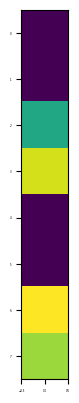

Hash(input):  ((8, 1), (109.5598050113, 215.6201718589))
Hash(params):  ((1, 9), (4.2071201491, -3.8035055264))
Hash(output):  (16.4137745547, 16.4137745547)


array([[16.41377455]])

In [103]:
net.getOutputLayer(x_in[1], len(net.network)-2, noisy = True)

#sprint6: using Keras to compare

Epoch 1/100
100/100 [==============================] - 2s 4ms/step - loss: 1.6140 - accuracy: 0.7500
Epoch 2/100
100/100 [==============================] - 0s 3ms/step - loss: 0.2605 - accuracy: 0.9400
Epoch 3/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0482 - accuracy: 0.9900
Epoch 4/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0250 - accuracy: 0.9900
Epoch 5/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0058 - accuracy: 1.0000
Epoch 6/100
100/100 [==============================] - 0s 5ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 7/100
100/100 [==============================] - 0s 5ms/step - loss: 5.9717e-04 - accuracy: 1.0000
Epoch 8/100
100/100 [==============================] - 0s 5ms/step - loss: 4.7925e-04 - accuracy: 1.0000
Epoch 9/100
100/100 [==============================] - 0s 5ms/step - loss: 3.9170e-04 - accuracy: 1.0000
Epoch 10/100
100/100 [==============================] - 0s 5ms/step - loss: 3.3

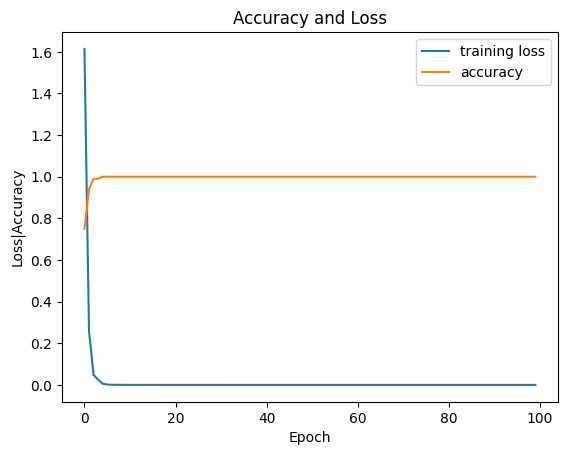

In [104]:
import keras
model = keras.Sequential()

model.add(keras.layers.Conv2D(1, (7, 7), activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(1, (3, 3), activation='relu'))

model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))

model.add(keras.layers.Dense(1, activation='sigmoid'))


model.compile(
  loss=keras.losses.BinaryCrossentropy(),
  optimizer=keras.optimizers.Adam(learning_rate = 1e-3),
  metrics=['accuracy'])


num_epoch = 100
H = model.fit(x_in, y_in, batch_size=1, epochs=num_epoch, verbose=1)


fig = plt.figure()

plt.plot( H.history['loss'], label='training loss')
# plt.plot(np.arange(0, num_epoch), H.history['val_loss'], label='validation loss')
plt.plot( H.history['accuracy'], label='accuracy')
# plt.plot(np.arange(0, num_epoch), H.history['val_accuracy'], label='validation accuracy')

plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()


In [105]:
# test data_out
model.evaluate(x_out, y_out, verbose = 1)

4/4 [==============================] - 0s 5ms/step - loss: 0.5985 - accuracy: 0.9400


[0.5984712243080139, 0.9399999976158142]

> wow, myCNN better Keras

# end